# SURGE Demo

Here, we simulate some data eQTL data (where the eQTL effect sizes change as function context) and assess SURGE's ability to re-capture the uknown contexts.

This notebook should also provide an example of how SURGE can be easily run within python.

In [25]:
import numpy as np
import surge_inference
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Simulate some data

To assess SURGE's ability to accurately capture contexts underlying context-specific eQTLs, we perform the following simulation experiment:

We randomly generated genotype and expression matrices across $T$ variant-gene-pairs and $N$ RNA samples. For each simulated variant-gene pair, we simulated the genotype vector ($G$) across the $N$ samples according to the following probability distributions:

$af_n \sim Uniform(.1,.9)$

$G_n \sim Binomial(2, af_n)$

Then we standardized genotype to have mean 0 and variance 1. We call the standardized genotype in the nth sample $G^*_n$

Next, we simulated the expression vector (y) across the $N$ samples using the following probability distributions (conditional on the simulated standardized genotype):

$y_n \sim N(\mu + \beta G^*_n +\sum_k G^*_n *U_{nk} V_k \theta_k, 1)$

$\mu \sim N(0,1)$

$\beta \sim N(0,1)$

$U_{nk} \sim N(0,1)$

$V_k \sim N(0, \gamma)$

$\theta_k \sim Bernoulli(p)$



This simulation, therefor, evaluates SURGE's ability to re-capture the simulated latent contexts (U) as a function of the simulation hyper-parameters:
- The number of latent contexts (K; num_components)
- The sample size (N; num_samples)
- The strength of the interaction terms ($\gamma$, t_statistic)
- The fraction of tests that are context-specific eQTLs for a particular context ($p$; missingness_fraction)




In [2]:
# Generate genotype vector for a particular snp
def get_genotype_vec(num_samples, af):
    allele1 = np.random.binomial(n=1, p=af,size=num_samples)
    allele2 = np.random.binomial(n=1, p=af,size=num_samples)
    genotype_vec = allele1 + allele2
    return genotype_vec

# Generate gene expression data (Y), and genotype data (G)
def generate_eqtl_factorization_data_with_no_sample_repeat(num_samples, num_tests, num_components, t_statistic, missingness_fraction):
    # Simulate genotype
    G = np.zeros((num_samples, num_tests))
    G_raw = np.zeros((num_samples, num_tests))
    for test_num in range(num_tests):
        af = np.random.uniform(.1,.9)
        # Get genotype for this particular snp
        genotype_vec = get_genotype_vec(num_samples, af)
        G_raw[:, test_num] = genotype_vec
        # Standardized genotype
        G[:, test_num] = (genotype_vec - np.mean(genotype_vec))/np.std(genotype_vec)

    # Simulate U
    U = np.random.standard_normal(size=(num_samples, num_components))
    for component_num in range(num_components):
        U[:, component_num] = (U[:, component_num] - np.mean(U[:, component_num]))/np.std(U[:, component_num])
    
    # Simulate V
    V = np.random.normal(loc=0.0, scale=t_statistic, size=(num_components, num_tests))
    # Add missingness to V
    for test_num in range(num_tests):
        for component_num in range(num_components):
            V[component_num, test_num] = V[component_num, test_num]*np.random.binomial(n=1,p=missingness_fraction)

    # Get Expected expression value of each (sample, gene) pair
    predicted_mean = np.zeros((num_samples, num_tests))  + G*np.dot(U,V)
    # Simulate genotype fixed effect size
    betas = []
    Y = np.zeros((num_samples, num_tests))
    for test_num in range(num_tests):
        beta = np.random.normal(loc=0.0, scale=.1)
        predicted_mean[:, test_num] = predicted_mean[:, test_num] + G[:, test_num]*beta
        Y[:, test_num] = np.random.normal(predicted_mean[:,test_num])
        betas.append(beta)
    
    # Standardized Y
    for test_num in range(num_tests):
        Y[:, test_num] = (Y[:, test_num] - np.mean(Y[:, test_num]))/np.std(Y[:, test_num])
    return Y, G, np.asarray(betas), U, V


In [19]:
# Simulation parameters
num_samples = 250
num_tests=1000
t_statistic = .75
missingness_fraction = .3
simulated_factor = 5
np.random.seed(2)

# Simulate the data
Y, G, betas, U_sim, V_sim = generate_eqtl_factorization_data_with_no_sample_repeat(num_samples, num_tests, simulated_factor, t_statistic, missingness_fraction)



## Run SURGE

At this point we have successfully simulated eQTL data. Notably we have generated an standardized expression matrix ($Y$) of dimension $N$X$T$ and we have generated a standardized genotype matrix ($G^*$) of dimension $N$X$T$. The $t^{th}$ column of $Y$ reflects the gene corresponding to the $t^{th}$ variant-gene pair. The $t^{th}$ column of $G$ reflects the variant corresponding to the $t^{th}$ variant-gene pair. Notably, each column of $Y$ has mean 0 and stardard deviation 1. Additionally, each column of $G$ has mean 0 and standard deviation 1.

Using this simulated data, we can run SURGE to re-discover the simulated contexts.

It is important to note that this simulated expression was not affected by covariates nor was simulated expression affected by sample repeat structure . Therefore, we ran we ran SURGE:
- We did not model the effects of covariates on gene expression in SURGE. However, covariates could be easily included by changing cov into a matrix that contains a column for each covariate (as well as column corresponding to the intercept). 
- We did not model the effects of sample repeat structure on gene expression in SURGE. However, sample repeat structure could easily be included by setting `re_boolean=True`, and by including `z=sample_repeat` as an arguement in `fit`. `sample_repeat` is a vector of length $N$ where each element is an integer corresponding to the individual that sample came from.

In [20]:
# Covariate matrix is just an intercept as there are no simulated covariates
cov = np.ones((num_samples, 1))

# Create SURGE object (w/ no sample repeat structure): 
surge_obj = surge_inference.SURGE_VI(K=10, re_boolean=False)
surge_obj.fit(G=G, Y=Y, cov=cov)


*********************************************************
SURGE
Single cell Unsupervised Regulation of Gene Expression
*********************************************************
###############################
Initialize variables
###############################
250 samples detected
1000 tests detected
10 latent factors detected
###############################
Begin Coordinate ascent variational inference (CAVI) iterative algorithm
###############################
Variational Inference iteration: 0
delta ELBO: 129431775.65202913
Variational Inference iteration: 1
delta ELBO: 29798.386386387458
Variational Inference iteration: 2
delta ELBO: 13840.992208941607
Variational Inference iteration: 3
delta ELBO: 1228.260650450131
Variational Inference iteration: 4
delta ELBO: 580.1020722674439
Variational Inference iteration: 5
delta ELBO: 5160.318474972562
Variational Inference iteration: 6
delta ELBO: 323.85973606217885
Variational Inference iteration: 7
delta ELBO: 251.49589751369786
Variatio

## Visualize learned SURGE latent contexts

SURGE optimization has converged. We can now visualize the results. 

First, we can examine the ELBO over variational iterations.

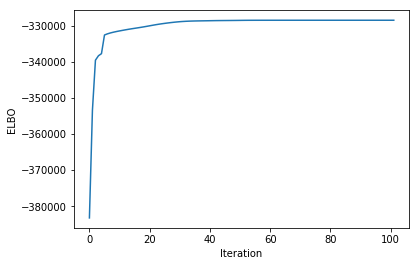

In [21]:
# check to make sure ELBO is monotonically increasing (Note: ELBO is gauranteed to monotonically increase)
plt.plot(surge_obj.elbo[1:]);  # Skipped first iteration in visualization b/c it is such a large change that it completely dominates the plot
plt.xlabel('Iteration');
plt.ylabel('ELBO');

Plot PVE by each of SURGE latent contexts

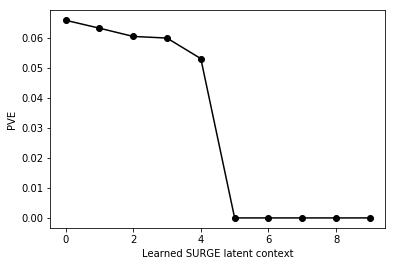

In [22]:
# Order SURGE contexts by PVE
context_order = np.argsort(-surge_obj.factor_pve)
# Plot PVE for each of latent contexts
plt.plot(surge_obj.factor_pve[context_order], '-ok');
plt.xlabel('Learned SURGE latent context');
plt.ylabel('PVE');

5 learned SURGE latent contenxts have non-zero PVE, whereas the other 5 SURGE latent contexts have approximately 0 PVE. This is expected given we simulated 5 latent contexts. 

Next, plot absolute correlation between learned SURGE latent contexts and simulated SURGE latent contexts. Here, we filter out non-informative learned latent contexts (ie those with PVE < 1e-4).

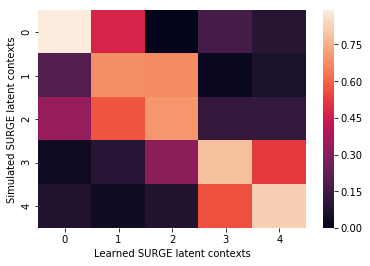

In [23]:
# Extact learned SURGE latent contexts (ordered by PVE)
U_learned = surge_obj.U_mu[:, context_order]
# Filter out contexts with PVE < 1e-4
context_pves = surge_obj.factor_pve[context_order]
U_learned = U_learned[:, context_pves >= 1e-4]

# Compute correlations
K_sim = U_sim.shape[1]
K_learned = U_learned.shape[1]
corr_mat = np.zeros((K_sim, K_learned))

for k_sim in range(K_sim):
    for k_learned in range(K_learned):
        corr_mat[k_sim, k_learned] = np.corrcoef(U_sim[:, k_sim], U_learned[:, k_learned])[0,1]

sns.heatmap(np.abs(corr_mat));
plt.xlabel('Learned SURGE latent contexts');
plt.ylabel('Simulated SURGE latent contexts');


As can be seen in the above heatmap, the learned SURGE latent contexts correlated with the simulated SURGE latent contexts. However, some of the simulated SURGE latent contexts are explained by multiple learned SURGE latent contexts. For example, simulated SURGE latent context 1 is correlated (nearly equally) with learned SURGE context 1 and 2. This result is unsuprising and is well-documented by dimensionality reduction theory: solutions are equivalent up to a rotation.

Another way to view how well the learned SURGE latent contexts capture the simulated SURGE latent contexts is to ask of much of the variance in a simulated SURGE latent context is explained by all of the SURGE latent contexts:

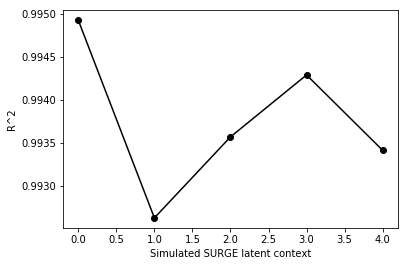

In [38]:
# Calculate R-squared in each simulated component
r_squared = []
for k_sim in range(K_sim):
    reg = LinearRegression().fit(U_learned, U_sim[:,k_sim])
    r_squared.append(reg.score(U_learned, U_sim[:,k_sim]))

# Plot
plt.plot(r_squared, '-ok');
plt.xlabel('Simulated SURGE latent context');
plt.ylabel('R^2');

## Extract parameters from fitted SURGE object

Now, we will go over some useful parameters to extract from the fitted SURGE object.


### 1. Expected value of SURGE latent contexts.

    This is a matrix of dimensions NXK where N is the number of samples and K is the number of latent contexts. An element of this matrix represents the estimated expected value of the SURGE latent context for a particular latent context for a particular sample.


In [45]:
print(surge_obj.U_mu)

[[ 7.21713046e-02 -3.39548570e-01  4.54565936e-02 ...  1.60970616e-44
  -2.37694134e-39 -6.37865469e-36]
 [ 4.16423892e-01  2.62823106e-01  6.57665245e-01 ...  2.26499691e-44
  -2.40368880e-39 -6.09820568e-36]
 [-7.45568081e-03  2.73837121e-01  2.80211695e-01 ... -8.67375325e-44
   4.30573902e-39 -6.92052068e-36]
 ...
 [-6.74711206e-02 -1.95070690e-01  4.53138742e-01 ...  8.74407045e-44
  -5.13937546e-39  4.37618070e-36]
 [-3.33973984e-01 -4.46804384e-01 -2.48794191e-01 ...  6.47022517e-46
  -1.07916392e-39 -3.03321405e-36]
 [-1.83613636e-01 -6.25296209e-02 -2.02194942e-01 ...  2.96737487e-44
  -1.19062154e-39  2.47900570e-36]]


### 2. Variance of SURGE latent contexts
   
    This a matrix of dimensions NXK where N is the number of samples and K is the number of latent contexts. An element of this matrix represents the estimated variance of the expected value of the SURGE latent contexts for a particular latent context for a particular sample.
   

In [46]:
print(surge_obj.U_var)

[[4.37046893e-04 5.03459476e-04 3.83465203e-04 ... 6.41695346e-05
  6.41695457e-05 6.41696106e-05]
 [4.01446788e-04 4.06868165e-04 4.16806372e-04 ... 6.38538020e-05
  6.38538130e-05 6.38538773e-05]
 [4.71028219e-04 4.16616503e-04 2.98092993e-04 ... 6.38654046e-05
  6.38654156e-05 6.38654799e-05]
 ...
 [4.16402086e-04 4.12642665e-04 4.55328821e-04 ... 6.42176568e-05
  6.42176679e-05 6.42177329e-05]
 [4.59551802e-04 4.07940036e-04 3.54331682e-04 ... 6.34603285e-05
  6.34603394e-05 6.34604029e-05]
 [4.08314995e-04 4.32778832e-04 3.96238054e-04 ... 6.40392635e-05
  6.40392746e-05 6.40393392e-05]]


### 3. ELBO
   
    This a vector of length number of variational iterations where each element represents that elbo at each iteration. Note, this vector is gauranteed to be monotonically increasing.

In [47]:
print(surge_obj.elbo)

[-129815003.44723517, -383227.7952060429, -353429.4088196554, -339588.4166107138, -338360.1559602637, -337780.05388799624, -332619.7354130237, -332295.8756769615, -332044.3797794478, -331835.90345591656, -331655.75803586433, -331491.1981388052, -331334.24883964896, -331182.61203489295, -331037.94583599456, -330901.9484316198, -330772.4094737088, -330643.58636874746, -330510.43806556106, -330371.0549323838, -330225.3389120355, -330074.36967323744, -329922.14899816137, -329775.33531808, -329639.33870649146, -329514.9940908966, -329399.8687615787, -329291.7352596342, -329190.25170060544, -329096.42293294665, -329011.5605574934, -328937.44773276965, -328875.9900838582, -328827.4128117815, -328789.83096854517, -328761.0050510714, -328739.26695496414, -328722.6686581497, -328708.8615688785, -328695.8724907758, -328682.4014495802, -328667.92442327546, -328653.088422794, -328639.6676217763, -328629.0956786356, -328621.1455859651, -328614.6136988612, -328608.39903226, -328601.69914870546, -3285

### 3. Percent variance explained of each of the SURGE latent contexts
   
    This is a vector of length number of latent contexts. Each element of this vector represents the PVE (Based on bottom of P21 of https://arxiv.org/pdf/1802.06931.pdf) of each of the SURGE latent contexts. Generally we filter out contexts based on those we PVE < 1e-4.

In [44]:
print(surge_obj.factor_pve)

[5.98351492e-002 5.29998620e-002 6.31273058e-002 6.03825018e-002
 6.57645904e-002 1.20653722e-195 3.77038347e-112 1.33085811e-170
 1.74339646e-151 3.03774920e-138]


### 4. Expected value of latent context effect sizes
   
    This is a matrix of dimensions KXT where T is the number of eqtl tests and K is the number of latent contexts. An element of this matrix represents the estimated interaction effect size corresponding to the latent context and eqtl of the element.

In [55]:
print(surge_obj.V_mu)

[[-1.67558235e+00 -1.53400700e-01 -1.39709555e-01 ... -2.53226483e-01
   5.44171908e-01 -4.58333963e-01]
 [-2.41401911e+00  4.07373169e-01  2.92907960e-01 ...  5.95813039e-01
  -1.65320564e+00 -1.13593041e-01]
 [-7.10088298e-01 -2.29041474e+00  9.04554108e-01 ...  6.46793479e-01
  -2.46690645e-02 -6.00542975e-02]
 ...
 [-1.28714439e-42  2.76481563e-42  6.23354208e-43 ... -1.55256389e-42
   2.64940653e-43  1.42275619e-42]
 [ 5.92645881e-38 -1.74256416e-37  1.07231015e-38 ...  5.21275872e-38
  -4.09700808e-38 -9.71007248e-38]
 [-6.84698227e-35 -4.96554469e-35  3.51343734e-34 ... -3.32056739e-34
  -1.00509084e-34 -7.65580262e-35]]


### 5. Variance of latent context effect sizes
   
    This is a matrix of dimensions KXT where T is the number of eqtl tests and K is the number of latent contexts. An element of this matrix represents the estimated interaction effect size variance corresponding to the latent context and eqtl of the element.

In [57]:
print(surge_obj.V_var)

[[0.01964454 0.01453338 0.04982145 ... 0.03650294 0.04207156 0.05150303]
 [0.01919928 0.0197433  0.05299103 ... 0.04330937 0.05472064 0.06100446]
 [0.018876   0.01418781 0.04559708 ... 0.03178958 0.04495676 0.06007321]
 ...
 [0.95207509 0.94420966 0.98024938 ... 0.97271498 0.98042584 0.9836474 ]
 [0.95207508 0.94420965 0.98024938 ... 0.97271498 0.98042584 0.98364739]
 [0.95207503 0.9442096  0.98024936 ... 0.97271495 0.98042582 0.98364738]]
